In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


import os

from IPython.display import display, Math
from numcosmo_py import Nc
from numcosmo_py import Ncm, GObject


# CCL
import pyccl as ccl
from pyccl.halos.massdef import MassDef
from astropy.io import fits
import sys 
import math 
from emantis.halo_mass_function import HMFEmulator
from astropy.table import Table
from scipy.integrate import dblquad
from scipy.interpolate import interp1d
import scipy
from astropy.table import Table
from scipy import stats
from astropy.io import fits

## Creating NumCosmo data with tinker for comparison

In [2]:
Omega_c = 0.262 
Omega_b = 0.049 
Omega_k = 0.0 
H0      = 67.66
h       = H0 / 100.0
Tcmb0   = 2.7255 
A_s     = 2.1e-9 
sigma8  = 0.8277 
n_s     = 0.96 
Neff    = 3.046
w0      = -1.0 
wa      = 0.0 
Tinker_lin_interp = True
area = 439.78986
Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

The number of clusters generated by NumCosmo is: 11893


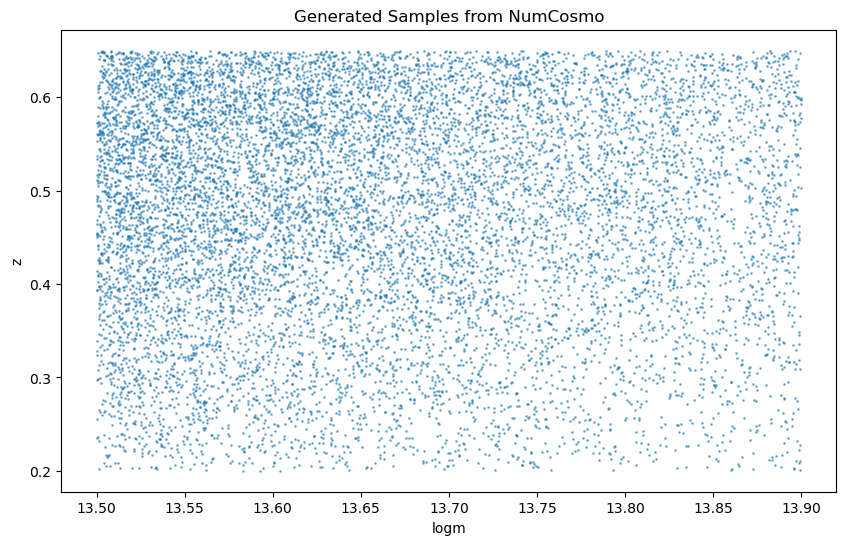

In [3]:
%matplotlib inline
H0 = 71.0
Ob0 = 0.0448
Odm0 = 0.22
n_s = 0.963
sigma8 = 0.8

cosmo = Nc.HICosmoDECpl()
reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)
tf = Nc.TransferFuncEH.new()

psml = Nc.PowspecMLTransfer.new(tf)

# psml = Nc.PowspecMLCBE.new ()
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()

cosmo.props.H0 = H0
cosmo.props.Omegab = Ob0
cosmo.props.Omegac = Odm0

cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0.0)

prim.props.n_SA = n_s

old_amplitude = math.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log((sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude)

# CosmoSim_proxy model
# M_0, z_0

area = 439.78986
lnRl = 0.0
lnRu = 5.0
zl = 0.2
zu = 0.65

# NumCosmo proxy model based on arxiv 1904.07524v2
cluster_z = Nc.ClusterRedshiftNodist(z_max=zu, z_min=zl)
cluster_m = Nc.ClusterMassAscaso(
    M0=3.0e14 / 0.71, z0=0.6, lnRichness_min=lnRl, lnRichness_max=lnRu
)
cluster_m.param_set_by_name("mup0", 3.19)
cluster_m.param_set_by_name("mup1", 2 / np.log(10))
cluster_m.param_set_by_name("mup2", -0.7 / np.log(10))
cluster_m.param_set_by_name("sigmap0", 0.33)
cluster_m.param_set_by_name("sigmap1", -0.08 / np.log(10))
cluster_m.param_set_by_name("sigmap2", 0 / np.log(10))

# Numcosmo Mass Function
# First we need to define the multiplicity function here we will use the tinker
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp(True)  # This reproduces the linear interpolation done in CCL
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200)

# Second we need to construct a filtered power spectrum
hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area_sd(area)

# Cluster Abundance Obj
ca = Nc.ClusterAbundance.new(hmf, None)

# Number Counts object
ncount = Nc.DataClusterNCount.new(
    ca, "NcClusterRedshiftNodist", "NcClusterMassAscaso"
)
ca.prepare(cosmo, cluster_z, cluster_m)
mset = Ncm.MSet.new_array([cosmo, cluster_z, cluster_m])

rng = Ncm.RNG.seeded_new(None, 2)
ncount.init_from_sampling(mset, area * ((np.pi / 180) ** 2), rng)

ncount.catalog_save("ncount_rich.fits", True)
ncdata_fits = fits.open("ncount_rich.fits")
ncdata_data = ncdata_fits[1].data  # pylint: disable-msg=no-member
ncdata_Table = Table(ncdata_data)

# ## Saving in SACC format

data_table = ncdata_Table[(ncdata_Table["LNM_TRUE"] / np.log(10) > 13.5) & (ncdata_Table["LNM_TRUE"] / np.log(10) < 13.9)]
cluster_z = data_table["Z_OBS"]
cluster_lnm = data_table["LNM_OBS"]
cluster_richness = cluster_lnm / np.log(10.0)
cluster_logM = data_table["LNM_TRUE"] / np.log(10.0)
print(f"The number of clusters generated by NumCosmo is: {len(data_table)}")
plt.figure(figsize=(10, 6))
plt.scatter(cluster_logM, cluster_z, s=1, alpha=0.5)
plt.xlabel("logm")
plt.ylabel("z")
plt.title("Generated Samples from NumCosmo")
plt.show()

## New class to generate data from Emantis

In [4]:
class ClusterDistribution:
    def __init__(self, area=439.78986, z_min=0.2, z_max=0.65, logm_min=13.5, logm_max=13.9):
        self.cosmo_ccl = ccl.Cosmology(
            Omega_b=0.0448, Omega_c=0.22, sigma8=0.8, w0=-1, wa=0, h=0.71, n_s=0.96
        )
        self.hmf_emu = HMFEmulator(model="wCDM", mass_def="200c")
        self.area = area
        self.z_min = z_min
        self.z_max = z_max
        self.logm_min = logm_min
        self.logm_max = logm_max
        self.norm_factor = None

    def dv_dn_dlnM(self, logm, z):
        a = 1. / (1. + z)
        val = self.hmf_emu.predict_hmf(10**logm, self.cosmo_parameters(), a)
        angular_diam_dist = ccl.angular_diameter_distance(self.cosmo_ccl, a)
        h_over_h0 = ccl.h_over_h0(self.cosmo_ccl, a)

        dV = (
            ccl.physical_constants.CLIGHT_HMPC
            * (angular_diam_dist**2)
            * ((1.0 + z) ** 2)
            / (self.cosmo_ccl["h"] * h_over_h0)
        )

        sky_area_rad = self.area * (np.pi / 180.0) ** 2
        volume = dV * sky_area_rad
        return val * volume * (0.71**3) * np.log(10)

    def cosmo_parameters(self):
        return {
            'Omega_b': 0.0448,
            'Omega_m': 0.0448 + 0.22,
            'sigma8': 0.8,
            'n_s': 0.96,
            'w': -1,
            'h': 0.71,
        }

    def points_number(self):
        integral, _ = dblquad(
            lambda logm, z: self.dv_dn_dlnM(logm, z),
            self.z_min, self.z_max,  # z range
            lambda _: np.log10(10**self.logm_min * 0.71),
            lambda _: np.log10(10**self.logm_max * 0.71),  # logm range
            epsabs=1.49e-4,
            epsrel=1.49e-4
        )
        return integral

    def normalize(self):
        if self.norm_factor is None:
            self.norm_factor = self.points_number()
        return self.norm_factor

    def normalized_dn_dlnM(self, logm, z):
        norm = self.normalize()
        return self.dv_dn_dlnM(logm, z) / norm

    def generate_samples(self):
        logm_vals = np.linspace(
            np.log10(10**self.logm_min * 0.71),
            np.log10(10**self.logm_max * 0.71),
            200
        )
        z_vals = np.linspace(self.z_min, self.z_max, 200)

        # Compute PDF values across the grid
        pdf_values = np.array([
            [self.normalized_dn_dlnM(logm, z) for logm in logm_vals]
            for z in z_vals
        ])

        # Compute CDF
        cdf_values = np.cumsum(pdf_values)
        cdf_values /= cdf_values[-1]  # Normalize CDF to [0, 1]

        # Flatten CDF for easier inverse transform sampling
        cdf_flat = cdf_values.ravel()
        logm_flat, z_flat = np.meshgrid(logm_vals, z_vals)
        logm_flat = logm_flat.ravel()
        z_flat = z_flat.ravel()

        # Interpolation for inverse sampling
        inv_cdf_logm = interp1d(cdf_flat, logm_flat, kind="linear", fill_value="extrapolate")
        inv_cdf_z = interp1d(cdf_flat, z_flat, kind="linear", fill_value="extrapolate")

        # Generate samples
        random_values = np.random.uniform(0, 1, int(self.norm_factor))
        sampled_logm_h = inv_cdf_logm(random_values)
        sampled_logm = np.log10(10**sampled_logm_h / 0.71)
        sampled_z = inv_cdf_z(random_values)
        return sampled_logm, sampled_z
    def generate_log10_richness(self, logm, z):
        lnm = logm * np.log(10)  # Convert log base-10 mass to natural logarithm
        mup0 = 3.19
        mup1 = 2 / np.log(10)
        mup2 = -0.7 / np.log(10)
        sigmap0 = 0.33
        sigmap1 = -0.08 / np.log(10)
        sigmap2 = 0 / np.log(10)
        pivot_mass = np.log(3.0e14 / 0.71)
        pivot_z = 0.6
        delta_ln_mass = lnm - pivot_mass
        delta_z = np.log1p(z) - np.log1p(pivot_z)
    
        # Compute the mean of the Gaussian distribution for lnL
        num = mup0 + mup1 * delta_ln_mass + mup2 * delta_z
        sigma = sigmap0 + sigmap1 * delta_ln_mass + sigmap2 * delta_z
        distribution = scipy.stats.norm(loc=num,scale=sigma)
        for i in range(0,100):
            sample = distribution.rvs(size=1)
            if sample > 0:
                break
        return sample[0] / np.log(10)

# Example usage
cluster_dist = ClusterDistribution()
print(f"The number of clusters generated by emantis is: {cluster_dist.normalize()}")

samples_logm, samples_z = cluster_dist.generate_samples()




e-MANTIS:hmf:200c:aexp_0.6667 Training the emulator...
e-MANTIS:hmf:200c:aexp_0.6667 ...training completed.
e-MANTIS:hmf:200c:aexp_0.7042 Training the emulator...
e-MANTIS:hmf:200c:aexp_0.7042 ...training completed.
e-MANTIS:hmf:200c:aexp_0.8 Training the emulator...
e-MANTIS:hmf:200c:aexp_0.8 ...training completed.
e-MANTIS:hmf:200c:aexp_0.8696 Training the emulator...
e-MANTIS:hmf:200c:aexp_0.8696 ...training completed.
e-MANTIS:hmf:200c:aexp_0.5882 Training the emulator...
e-MANTIS:hmf:200c:aexp_0.5882 ...training completed.
e-MANTIS:hmf:200c:aexp_0.625 Training the emulator...
e-MANTIS:hmf:200c:aexp_0.625 ...training completed.
e-MANTIS:hmf:200c:aexp_0.7692 Training the emulator...
e-MANTIS:hmf:200c:aexp_0.7692 ...training completed.
The number of clusters generated by emantis is: 12168.094405842898


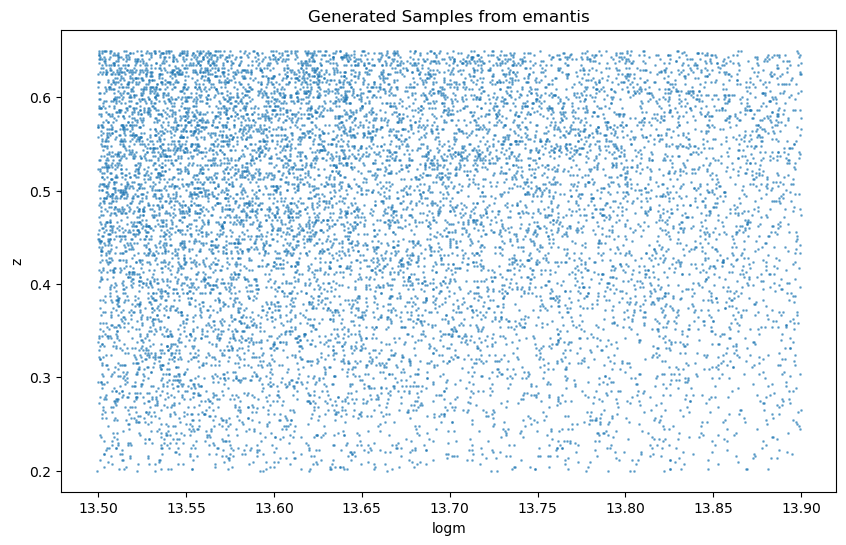

In [5]:
# Visualize samples
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.scatter(samples_logm, samples_z, s=1, alpha=0.5)
plt.xlabel("logm")
plt.ylabel("z")
plt.title("Generated Samples from emantis")
plt.show()

## Generating richness for emantis and comparing to NumCosmo

In [6]:
richness_l = [cluster_dist.generate_log10_richness(samples_logm[i], samples_z[i]) for i in range(0, len(samples_logm))]

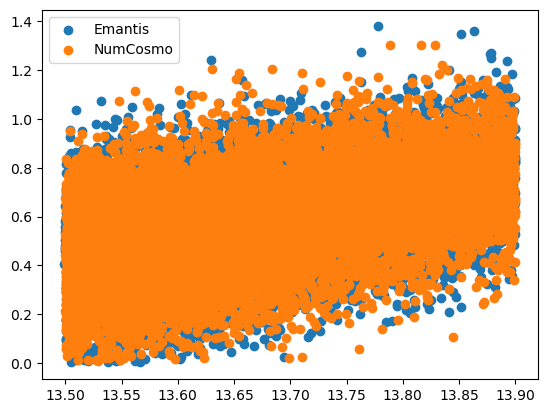

In [7]:
%matplotlib inline
plt.scatter(samples_logm,richness_l, label='Emantis' )
plt.scatter(cluster_logM,cluster_richness,label='NumCosmo')
plt.legend()

## Binning Emantis data
Just to be sure, let`s also bin the NumCosmo data to compare

In [8]:
N_richness = 5  # number of richness bins
N_z = 4  # number of redshift bins

cluster_counts, z_edges, richness_edges, _ = stats.binned_statistic_2d(
    cluster_z, cluster_richness, cluster_logM, "count", bins=[N_z, N_richness]
)
print(f'NumCosmo cluster counts \n{cluster_counts}\n')

cluster_counts, z_edges, richness_edges, _ = stats.binned_statistic_2d(
    np.array(samples_z), np.array(richness_l), np.array(samples_logm), "count", bins=[N_z, N_richness]
)
print(f'Emantis cluster counts \n{cluster_counts}')


NumCosmo cluster counts 
[[  82.  478.  695.  199.   14.]
 [ 162.  849. 1089.  320.   23.]
 [ 272. 1318. 1565.  446.   35.]
 [ 357. 1623. 1863.  476.   27.]]

Emantis cluster counts 
[[ 110.  561.  662.  165.    4.]
 [ 176. 1061. 1059.  261.    8.]
 [ 330. 1440. 1514.  310.    7.]
 [ 388. 1903. 1849.  341.   19.]]


## Saving to fits format
Be sure to change the path if needed. We are saving the list for all the clusters

In [9]:
# Create an Astropy Table
data_table = Table(
    [samples_logm, samples_z, richness_l],
    names=("logm", "z", "richness_l"),
    dtype=("f4", "f4", "f4")  # Data types: 32-bit floating point
)

# Save the table to a FITS file
fits_filename = "/pbs/home/e/ebarroso/mass_func/cluster_emantis_data.fits"
data_table.write(fits_filename, format="fits", overwrite=True)

## Saving to SACC format
Be sure to change the path if needed

In [10]:
os.environ["CLMM_MODELING_BACKEND"] = (
    "nc"  # Need to use NumCosmo as CLMM's backend as well.
)
import clmm  # noqa: E402
from clmm import Cosmology  # noqa: E402
import sacc
import itertools

In [26]:
mean_logM = stats.binned_statistic_2d(
    samples_z,
    richness_l,
    samples_logm,
    "mean",
    bins=[z_edges, richness_edges],
).statistic
std_logM = stats.binned_statistic_2d(samples_z, richness_l, samples_logm, "std", bins=[z_edges, richness_edges]).statistic

var_mean_logM = std_logM**2 / cluster_counts
# Use CLMM to create a mock DeltaSigma profile to add to the SACC file later
cosmo_clmm = clmm.Cosmology()
cosmo_clmm._init_from_cosmo(cosmo)
moo = clmm.Modeling(massdef="mean", delta_mdef=200, halo_profile_model="nfw")
moo.set_cosmo(cosmo_clmm)
# assuming the same concentration for all masses. Not realistic,
# but avoid having to call a mass-concentration relation.
moo.set_concentration(4)

# we'll need the mean redshift of the clusters in the redshift bin
mean_z = stats.binned_statistic_2d(
    samples_z,
    richness_l,
    samples_z,
    "mean",
    bins=[z_edges, richness_edges],
).statistic

radius_edges = clmm.make_bins(
    0.3, 6.0, nbins=6, method="evenlog10width"
)  # 6 radial bins log-spaced between 0.3 and 6 Mpc

radius_centers = []
for i, radius_bin in enumerate(zip(radius_edges[:-1], radius_edges[1:])):
    radius_lower, radius_upper = radius_bin
    j = i + 2
    radius_center = np.mean(radius_edges[i:j])
    radius_centers.append(radius_center)

cluster_DeltaSigma = []
for redshift, log_mass in zip(samples_z, samples_logm):
    mass = 10**log_mass
    moo.set_mass(mass)
    cluster_DeltaSigma.append(
        moo.eval_excess_surface_density(radius_centers, redshift)
    )
cluster_DeltaSigma = np.array(cluster_DeltaSigma)
richness_inds = np.digitize(richness_l, richness_edges) - 1
z_inds = np.digitize(samples_z, z_edges) - 1
std_DeltaSigma = np.array(
    [
        [
            np.std(cluster_DeltaSigma[(richness_inds == i) * (z_inds == j)], axis=0)
            for i in range(N_richness)
        ]
        for j in range(N_z)
    ]
)
var_mean_DeltaSigma = std_DeltaSigma**2 / cluster_counts[..., None]
# correlation matrix - the "large blocks" correspond to the $N_z$ redshift bins.
# In each redshift bin are the $N_{\rm richness}$ richness bins.**
covariance = np.diag(
    np.concatenate(
        (
            cluster_counts.flatten(),
            var_mean_logM.flatten(),
            var_mean_DeltaSigma.flatten(),
        )
    )
)
# Prepare the SACC file
s_count = sacc.Sacc()
bin_z_labels = []
bin_richness_labels = []
bin_radius_labels = []

survey_name = "numcosmo_simulated_redshift_richness_deltasigma"
s_count.add_tracer("survey", survey_name, area)

for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
    lower, upper = z_bin
    bin_z_label = f"bin_z_{i}"
    s_count.add_tracer("bin_z", bin_z_label, lower, upper)
    bin_z_labels.append(bin_z_label)

for i, richness_bin in enumerate(zip(richness_edges[:-1], richness_edges[1:])):
    lower, upper = richness_bin
    bin_richness_label = f"rich_{i}"
    s_count.add_tracer("bin_richness", bin_richness_label, lower, upper)
    bin_richness_labels.append(bin_richness_label)

for i, radius_bin in enumerate(zip(radius_edges[:-1], radius_edges[1:])):
    radius_lower, radius_upper = radius_bin
    j = i + 2
    radius_center = np.mean(radius_edges[i:j])
    bin_radius_label = f"bin_radius_{i}"
    s_count.add_tracer(
        "bin_radius", bin_radius_label, radius_lower, radius_upper, radius_center
    )
    bin_radius_labels.append(bin_radius_label)

#  pylint: disable-next=no-member
cluster_count = sacc.standard_types.cluster_counts
#  pylint: disable-next=no-member
cluster_mean_log_mass = sacc.standard_types.cluster_mean_log_mass
#  pylint: disable-next=no-member
cluster_mean_DeltaSigma = sacc.standard_types.cluster_shear

counts_and_edges = zip(
    cluster_counts.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)

mean_logM_and_edges = zip(
    mean_logM.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)

redshifts_masses_and_edges = zip(
    mean_z.flatten(),
    mean_logM.flatten(),
    itertools.product(bin_z_labels, bin_richness_labels),
)

for counts, (bin_z_label, bin_richness_label) in counts_and_edges:
    s_count.add_data_point(
        cluster_count, (survey_name, bin_z_label, bin_richness_label), int(counts)
    )

for bin_mean_logM, (bin_z_label, bin_richness_label) in mean_logM_and_edges:
    s_count.add_data_point(
        cluster_mean_log_mass,
        (survey_name, bin_z_label, bin_richness_label),
        bin_mean_logM,
    )

for (
    redshift,
    log_mass,
    (bin_z_label, bin_richness_label),
) in redshifts_masses_and_edges:
    for i, bin_radius_label in enumerate(bin_radius_labels):
        mass = 10**log_mass
        moo.set_mass(mass)
        profile = moo.eval_excess_surface_density(radius_centers[i], redshift)
        s_count.add_data_point(
            cluster_mean_DeltaSigma,
            (survey_name, bin_z_label, bin_richness_label, bin_radius_label),
            profile,
        )
# ### Then the add the covariance and save the file
s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("/pbs/home/e/ebarroso/mass_func/cluster_redshift_richness_deltasigma_sacc_data.fits", overwrite=True)


s_count.data

[DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_0', 'rich_0'), value=82, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_0', 'rich_1'), value=478, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_0', 'rich_2'), value=695, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_0', 'rich_3'), value=199, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_0', 'rich_4'), value=14, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_1', 'rich_0'), value=162, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_1', 'rich_1'), value=849, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo

In [27]:
test = sacc.Sacc.load_fits("/pbs/home/e/ebarroso/mass_func/cluster_redshift_richness_deltasigma_sacc_data.fits")

In [28]:
print(test.data)

[DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_0', 'rich_0'), value=82, ), DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_0', 'rich_1'), value=478, ), DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_0', 'rich_2'), value=695, ), DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_0', 'rich_3'), value=199, ), DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_0', 'rich_4'), value=14, ), DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_1', 'rich_0'), value=162, ), DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness_deltasigma', 'bin_z_1', 'rich_1'), value=849, ), DataPoint(data_type='cluster_counts', tracers=('numcosmo_simula